Epoch [10/100], Loss: 0.2329
Epoch [20/100], Loss: 0.0687
Epoch [30/100], Loss: 0.0246
Epoch [40/100], Loss: 0.0104
Epoch [50/100], Loss: 0.0100
Epoch [60/100], Loss: 0.0096
Epoch [70/100], Loss: 0.0086
Epoch [80/100], Loss: 0.0073
Epoch [90/100], Loss: 0.0057
Epoch [100/100], Loss: 0.0036


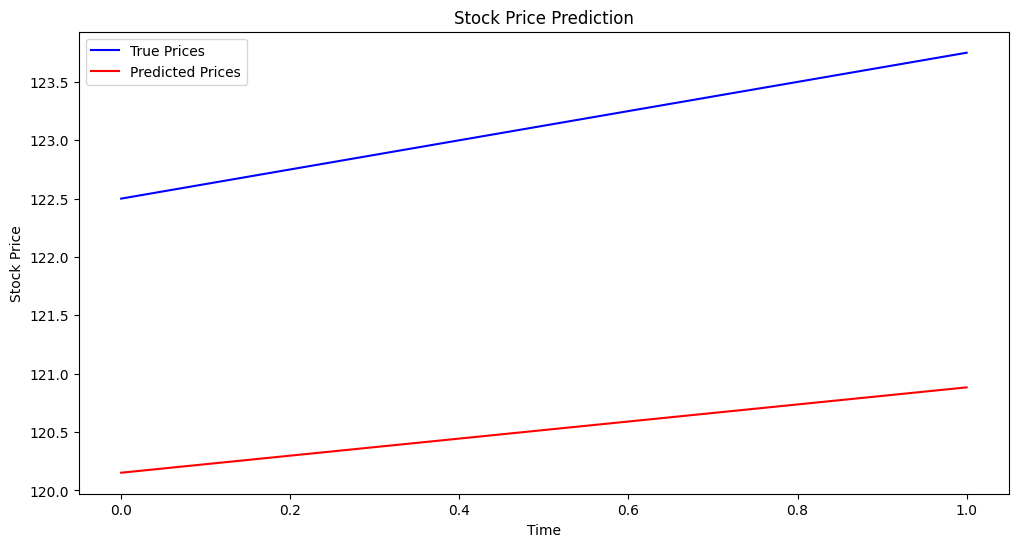

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load your stock price data
# Replace 'your_stock_price_data.csv' with your dataset's path
dataset = pd.read_csv('stock.csv')
dataset = dataset[['Close']]  # Assuming 'Close' column contains the stock prices

# Normalize the data
scaler = MinMaxScaler()
dataset['Close'] = scaler.fit_transform(dataset['Close'].values.reshape(-1, 1))

# Prepare the data
def prepare_data(data, seq_length):
    data = data.values
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 10  # Sequence length
x, y = prepare_data(dataset, seq_length)

# Split the data into training and testing sets
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = 1  # Number of features (in this case, it's the closing stock price)
hidden_size = 64  # Number of LSTM units
num_layers = 2  # Number of LSTM layers
output_size = 1  # Number of output units (1 for regression)

model = LSTM(input_size, hidden_size, num_layers, output_size)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    inputs = torch.Tensor(x_train)
    targets = torch.Tensor(y_train)
    
    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test the model
model.eval()
test_data = torch.Tensor(x_test)
test_outputs = model(test_data)

# Denormalize the data
test_outputs = scaler.inverse_transform(test_outputs.data.numpy())
y_test = scaler.inverse_transform(y_test)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Prices', color='blue')
plt.plot(test_outputs, label='Predicted Prices', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
